In [30]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import time

%matplotlib inline

In [31]:
# I read the data file and I import only the columns I'm interested in.

flights = pd.read_csv("BOS_CUN_trips1M.csv",)

dates = flights[['departure', 'return', 'triptimestamp', 'total']]

dates.head()

,departure,return,triptimestamp,total
0,1394789400,1395503700,1382317607,631.45
1,1394829000,1395498600,1382317607,632.95
2,1394804580,1395518400,1382317607,620.95
3,1394789400,1395498600,1382317607,632.95
4,1394789400,1395518400,1382317607,565.95


In [32]:
# First, I need to convert the dates into floats in order to be able to do anything with them later.

dates = dates.astype(float)

dates.dtypes

departure        float64
return           float64
triptimestamp    float64
total            float64
dtype: object

In [33]:
# I now can convert epoch time (in seconds) into UCT.

dates['triptimestamp'] = pd.to_datetime(dates['triptimestamp'], unit='s')

dates['departure'] = pd.to_datetime(dates['departure'], unit='s')
dates['return'] = pd.to_datetime(dates['return'], unit='s')

dates.head()

,departure,return,triptimestamp,total
0,2014-03-14 09:30:00,2014-03-22 15:55:00,2013-10-21 01:06:47,631.45
1,2014-03-14 20:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
2,2014-03-14 13:43:00,2014-03-22 20:00:00,2013-10-21 01:06:47,620.95
3,2014-03-14 09:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
4,2014-03-14 09:30:00,2014-03-22 20:00:00,2013-10-21 01:06:47,565.95


In [35]:
# Firstly, I convert all the dates into strings that I can parse
dates['departure'] = dates['departure'].astype(str)
dates['return'] = dates['return'].astype(str)
dates['triptimestamp'] = dates['triptimestamp'].astype(str)

dates.head()

,departure,return,triptimestamp,total
0,2014-03-14 09:30:00,2014-03-22 15:55:00,2013-10-21 01:06:47,631.45
1,2014-03-14 20:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
2,2014-03-14 13:43:00,2014-03-22 20:00:00,2013-10-21 01:06:47,620.95
3,2014-03-14 09:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
4,2014-03-14 09:30:00,2014-03-22 20:00:00,2013-10-21 01:06:47,565.95


In [36]:
# I now want to take each column and convert it into a Series so I can parse strings in each of them.
# I then concatenate them back together.

departuredates = dates['departure']
returndates = dates['return']
timestamp = dates['triptimestamp']
datestotal = dates['total']

departuredates = pd.Series(departuredates)
returndates = pd.Series(returndates)
timestamp = pd.Series(timestamp)

departuresplit = departuredates.str.split(' ', expand=True)
returndatesplit = returndates.str.split(' ', expand=True)
timestampsplit = timestamp.str.split(' ', expand=True)

departuresplit.columns = 'departure dates', 'departure times'
returndatesplit.columns = 'return dates', 'return times'
timestampsplit.columns = 'timestamp dates', 'timestamp times'

frames = [departuresplit, returndatesplit, timestampsplit, datestotal]

concat = pd.concat(frames, axis=1, join_axes=[departuresplit.index])

concat.head()

,departure dates,departure times,return dates,return times,timestamp dates,timestamp times,total
0,2014-03-14,09:30:00,2014-03-22,15:55:00,2013-10-21,01:06:47,631.45
1,2014-03-14,20:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95
2,2014-03-14,13:43:00,2014-03-22,20:00:00,2013-10-21,01:06:47,620.95
3,2014-03-14,09:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95
4,2014-03-14,09:30:00,2014-03-22,20:00:00,2013-10-21,01:06:47,565.95


In [37]:
# I now want to find the day of the week on the timestamp to then work out day of the week.

concat['timestamp dates'] = pd.to_datetime(concat['timestamp dates'])
concat['day_of_week'] = concat['timestamp dates'].dt.dayofweek

days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}

concat['day_of_week'] = concat['day_of_week'].apply(lambda x: days[x])

concat.head()

,departure dates,departure times,return dates,return times,timestamp dates,timestamp times,total,day_of_week
0,2014-03-14,09:30:00,2014-03-22,15:55:00,2013-10-21,01:06:47,631.45,Mon
1,2014-03-14,20:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95,Mon
2,2014-03-14,13:43:00,2014-03-22,20:00:00,2013-10-21,01:06:47,620.95,Mon
3,2014-03-14,09:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95,Mon
4,2014-03-14,09:30:00,2014-03-22,20:00:00,2013-10-21,01:06:47,565.95,Mon


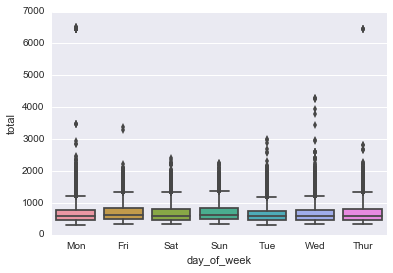

In [38]:
# I now produce a quick visualisation to see when it's best to book the flight.

sns.boxplot(concat['day_of_week'], concat['total'])

In [39]:
'''I can see that the two furthest outliers are above $6,000. I want to see close the distribution so I will
just look at the data with prices below $5,000'''

concat2 = concat[concat['total'] < 6000]

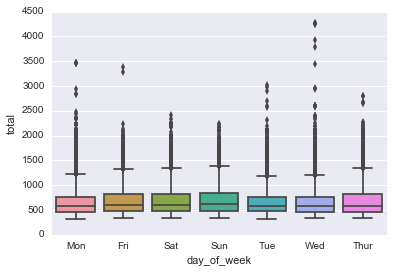

In [40]:
sns.boxplot(concat2['day_of_week'], concat2['total'])

In [42]:
# I now want to see the mean price for each day of the week.

concat.groupby('day_of_week').mean()

,total
day_of_week,
Fri,695.859330
Mon,658.797686
Sat,683.030484
Sun,699.856178
Thur,678.577925
Tue,658.865848
Wed,659.666595


In [ ]:
# I can see that the flights are marginally cheaper on Mondays and Tuesdays.